2025-07-27 03:42:03,911 — INFO — 🚀 Starting XGBoost HPO with Cross-Validation...
2025-07-27 03:42:04,014 — INFO — Data loaded successfully from d:\Projects\aki_prediction_project\data\processed\waveform_catch22_features_sliding_window.csv
2025-07-27 03:42:04,023 — INFO — Data split into main training set (3805 samples) and hold-out test set (952 samples).
2025-07-27 03:42:04,024 — INFO — Starting Optuna study with 100 trials and 5-Fold CV...


--- Libraries imported and logging configured ---
Project Root set to: d:\Projects\aki_prediction_project
Data directory set to: d:\Projects\aki_prediction_project\data\processed
--- Optuna objective function with Stratified K-Fold CV defined ---


  0%|          | 0/100 [00:00<?, ?it/s]

2025-07-27 03:43:38,622 — INFO — HPO complete. Training and evaluating the best model on the hold-out test set...
2025-07-27 03:43:45,370 — INFO — Best threshold found on test set: 0.16



--- 📊 Final Model Performance on Hold-Out Test Set ---


Metric  Score
0                 AUROC 0.5773
1                 AUPRC 0.0222
2              Accuracy 0.9790
3             Precision 0.0714
4  Sensitivity (Recall) 0.1250
5  F1-Score (Maximized) 0.0909
6           Specificity 0.9862

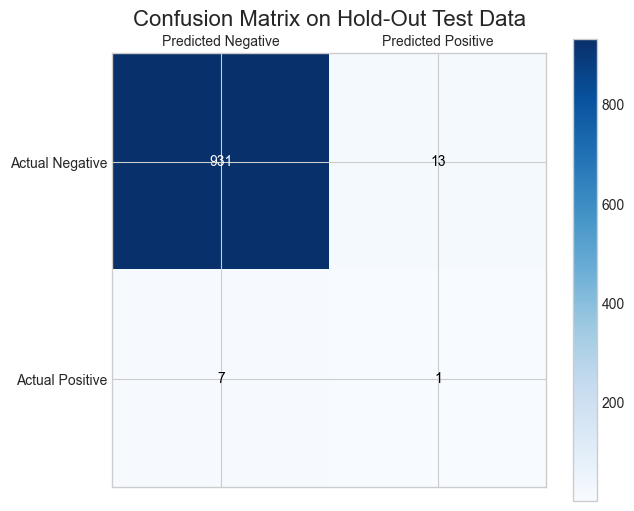

2025-07-27 03:43:45,574 — INFO — Calculating SHAP values for model explainability...



--- SHAP Feature Importance ---


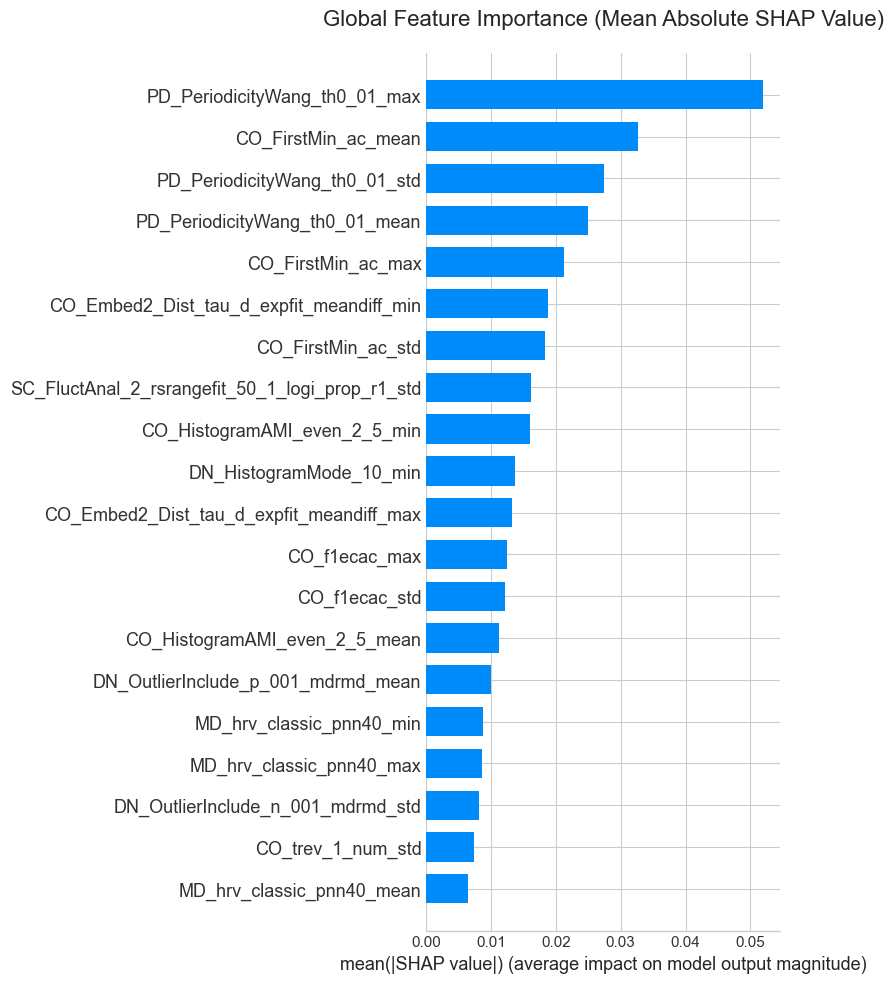

2025-07-27 03:43:47,855 — INFO — Best parameters written to d:\Projects\aki_prediction_project\results\xgboost_sliding_window_bootstrap\hpo_best_params_from_notebook_cv.txt



--- Best Hyperparameters (Copy-Paste Ready) ---
hpo_params_xgboost = {
    'n_estimators': 1400,
    'learning_rate': 0.00034898010421986915,
    'max_depth': 9,
    'subsample': 0.9634335513150067,
    'colsample_bytree': 0.6311601528618799,
    'gamma': 1.7321005335634188,
    'reg_lambda': 0.89884911281541,
    'reg_alpha': 4.455836417400764e-05,
    'scale_pos_weight': np.float64(10.858464440241999),
}


In [12]:
# =============================================================================
# HPO with Cross-Validation, Final Evaluation & SHAP Analysis
#
# This script performs a complete ML workflow in a single notebook:
# 1. Splits data into a main training set and a final, hold-out test set.
# 2. Performs Optuna HPO using Stratified K-Fold Cross-Validation on the
#    main training set for robust hyperparameter tuning.
# 3. Trains a final model on the entire main training set using the best params.
# 4. Evaluates the final model on the hold-out test set, including finding
#    an optimal threshold, plotting a confusion matrix, and generating SHAP plots.
#
# NOTE: This notebook is designed to be run from a 'notebooks' subdirectory
# within your main project folder.
# =============================================================================

# --- Cell 1: Imports and Setup -----------------------------------------------
import time
import logging
from pathlib import Path

import pandas as pd
import numpy as np
import optuna
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
from xgboost.callback import EarlyStopping
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s — %(levelname)s — %(message)s",
)
optuna.logging.set_verbosity(optuna.logging.WARNING)
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.float_format', lambda x: '%.4f' % x)

print("--- Libraries imported and logging configured ---")


# --- Cell 2: Configuration and Paths -----------------------------------------
N_TRIALS = 100 # Number of HPO trials
N_SPLITS = 5   # Number of folds for cross-validation
RANDOM_STATE = 42
INPUT_CSV = "waveform_catch22_features_sliding_window.csv"
TARGET_COLUMN = "death_label"

PROJECT_ROOT = Path.cwd().parent
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
RESULTS_DIR = PROJECT_ROOT / "results" / "xgboost_sliding_window_bootstrap"
HPO_RESULTS_FILE = RESULTS_DIR / "hpo_best_params_from_notebook_cv.txt"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Project Root set to: {PROJECT_ROOT}")
print(f"Data directory set to: {PROCESSED_DIR}")


# --- Cell 3: Optuna Objective Function with Cross-Validation -----------------
def objective(trial, X, y):
    """Optuna objective that uses Stratified K-Fold CV and returns mean AUROC."""
    
    cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
    auroc_scores = []

    # Calculate scale_pos_weight on the full training data once
    neg, pos = np.bincount(y)
    spw = np.sqrt(neg / pos) if pos > 0 else 1.0

    params = {
        "objective": "binary:logistic", "booster": "gbtree", "eval_metric": "auc",
        "tree_method": "hist", "n_jobs": -1, "random_state": RANDOM_STATE, "verbosity": 0,
        "scale_pos_weight": spw,
        "n_estimators": trial.suggest_int("n_estimators", 200, 2000, step=100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.05, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 1.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 1.0, log=True),
        # FIX: Removed `save_best=True` which can cause an error if a model
        # in a CV fold trains for all epochs without stopping early. The core
        # functionality of stopping at the best iteration is retained.
        "callbacks": [EarlyStopping(rounds=50)],
    }

    for train_idx, val_idx in cv.split(X, y):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        scaler = StandardScaler()
        X_tr_s = scaler.fit_transform(X_tr)
        X_val_s = scaler.transform(X_val)

        model = xgb.XGBClassifier(**params)
        model.fit(X_tr_s, y_tr, eval_set=[(X_val_s, y_val)], verbose=False)
        
        y_hat = model.predict_proba(X_val_s)[:, 1]
        auroc_scores.append(roc_auc_score(y_val, y_hat))

    return np.mean(auroc_scores)

print("--- Optuna objective function with Stratified K-Fold CV defined ---")


# --- Cell 4: Main Execution Block --------------------------------------------
def run_hpo_and_evaluate():
    """Main function to run the entire HPO and evaluation pipeline."""
    logging.info("🚀 Starting XGBoost HPO with Cross-Validation...")

    # ---------- Load Data ----------
    csv_path = PROCESSED_DIR / INPUT_CSV
    try:
        df = pd.read_csv(csv_path).dropna()
        X = df.drop(columns=["caseid", TARGET_COLUMN])
        y = df[TARGET_COLUMN]
        logging.info(f"Data loaded successfully from {csv_path}")
    except (FileNotFoundError, KeyError) as e:
        logging.error(f"Error loading data: {e}")
        return

    # ---------- Create a final hold-out test set ----------
    # HPO will be performed on X_train_main, y_train_main
    X_train_main, X_test, y_train_main, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
    )
    logging.info(f"Data split into main training set ({len(y_train_main)} samples) and hold-out test set ({len(y_test)} samples).")

    # ---------- Optuna Study with CV ----------
    logging.info(f"Starting Optuna study with {N_TRIALS} trials and {N_SPLITS}-Fold CV...")
    study = optuna.create_study(direction="maximize")
    study.optimize(
        lambda trial: objective(trial, X_train_main, y_train_main),
        n_trials=N_TRIALS,
        show_progress_bar=True,
    )

    # ---------- Train and Evaluate Final Model on Hold-Out Set ----------
    logging.info("HPO complete. Training and evaluating the best model on the hold-out test set...")
    
    best_params = dict(study.best_params)
    neg, pos = np.bincount(y_train_main)
    best_params["scale_pos_weight"] = np.sqrt(neg / pos) if pos > 0 else 1.0
    
    # Note: The 'callbacks' parameter from HPO is not needed for the final model
    final_model_params = {
        "objective": "binary:logistic", "booster": "gbtree", "tree_method": "hist",
        "n_jobs": -1, "random_state": RANDOM_STATE, **best_params,
    }

    # Scale the full main training set and the test set
    scaler = StandardScaler()
    X_train_main_s = scaler.fit_transform(X_train_main)
    X_test_s = scaler.transform(X_test)

    # Train final model
    final_model = xgb.XGBClassifier(**final_model_params)
    final_model.fit(X_train_main_s, y_train_main)
    
    y_test_pred_proba = final_model.predict_proba(X_test_s)[:, 1]

    # --- Find Optimal Threshold on Test Set ---
    thresholds = np.arange(0.01, 1.0, 0.01)
    f1_scores = [f1_score(y_test, y_test_pred_proba >= t) for t in thresholds]
    best_threshold = thresholds[np.argmax(f1_scores)]
    logging.info(f"Best threshold found on test set: {best_threshold:.2f}")
    y_test_pred_class = (y_test_pred_proba >= best_threshold).astype(int)

    # --- Calculate All Performance Metrics ---
    metrics = {
        'AUROC': roc_auc_score(y_test, y_test_pred_proba),
        'AUPRC': average_precision_score(y_test, y_test_pred_proba),
        'Accuracy': accuracy_score(y_test, y_test_pred_class),
        'Precision': precision_score(y_test, y_test_pred_class, zero_division=0),
        'Sensitivity (Recall)': recall_score(y_test, y_test_pred_class),
        'F1-Score (Maximized)': f1_score(y_test, y_test_pred_class)
    }
    tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_class).ravel()
    metrics['Specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    metrics_df = pd.DataFrame(metrics.items(), columns=['Metric', 'Score'])
    print("\n--- 📊 Final Model Performance on Hold-Out Test Set ---")
    display(metrics_df.round(4))

    # --- Plot Confusion Matrix ---
    cm = confusion_matrix(y_test, y_test_pred_class)
    fig, ax = plt.subplots(figsize=(7, 6))
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'), ha="center", va="center",
                    color="white" if cm[i, j] > cm.max()/2. else "black")
    ax.set_xticks(np.arange(2)), ax.set_yticks(np.arange(2))
    ax.set_xticklabels(['Predicted Negative', 'Predicted Positive'])
    ax.set_yticklabels(['Actual Negative', 'Actual Positive'])
    plt.title('Confusion Matrix on Hold-Out Test Data', fontsize=16, pad=20)
    plt.show()

    # --- SHAP Analysis ---
    logging.info("Calculating SHAP values for model explainability...")
    explainer = shap.TreeExplainer(final_model)
    shap_values = explainer.shap_values(X_test_s)
    
    print("\n--- SHAP Feature Importance ---")
    shap.summary_plot(shap_values, X_test_s, feature_names=X.columns, plot_type="bar", show=False)
    plt.title("Global Feature Importance (Mean Absolute SHAP Value)", fontsize=16, pad=20)
    plt.show()

    # --- Print Final Parameters ---
    output_string_list = ["hpo_params_xgboost = {"]
    for k, v in best_params.items():
        output_string_list.append(f"    '{k}': {v!r},")
    output_string_list.append("}")
    final_output_string = "\n".join(output_string_list)
    
    print("\n--- Best Hyperparameters (Copy-Paste Ready) ---")
    print(final_output_string)

    with open(HPO_RESULTS_FILE, "w") as f:
        f.write(f"# Hyperparameters saved on {time.ctime()}\n")
        f.write(f"# Best CV AUROC from HPO: {study.best_value:.4f}\n")
        f.write(final_output_string)
    logging.info(f"Best parameters written to {HPO_RESULTS_FILE}")


# --- Cell 5: Run the Full Pipeline -------------------------------------------
run_hpo_and_evaluate()
